In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
import langdetect

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [59]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
#     print(s)
    if langdetect.detect(s) == 'en':
        s = unicodeToAscii(s.lower().strip())
#         print(s)
        s = re.sub(r"([.!?])", r" \1", s)
#         print(s)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
#         print(s)
    else :
         s = s.lower().strip()
    return s

In [60]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='UTF-8').\
        read().strip().split('\n')
    
#     lines = lines[:1]
#     print(lines)

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
#     print(pairs[:1])

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [61]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [62]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
#     print(pairs[:1])
    print("Read %s sentence pairs" % len(pairs))
    print("At prepare data\n", pairs)
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs




In [63]:
input_lang, output_lang, pairs = prepareData('eng', 'tam', True)
print(random.choice(pairs))

Reading lines...
Read 197 sentence pairs
At prepare data
 [['நான் தூங்கினேன்.', 'i slept.'], ['அமைதியாக இருங்கள்', 'calm down .'], ['நான் நடப்பேன்.', "i'll walk."], ['அவன் யார்?', 'who is he ?'], ['யாருக்குத் தெரியும்?', 'who knows ?'], ['அவள் சிரித்தாள்', 'she smiled .'], ['என்னிடம் பேசு', 'talk to me!'], ['அவள் யார்?', 'who is she ?'], ['போய் தூங்கு', 'go to sleep.'], ['மழை பெய்யலாம்', 'it may rain .'], ['அவள் அவனைக் கடித்தாள்', 'she bit him.'], ['அவள் அவனைக் அடித்தாள்', 'she hit him.'], ['அவள் அன்பானவள்', 'she is kind .'], ['அவளுக்கு எட்டு வயது', 'she is eight .'], ['நாம் எங்கே இருக்கிறோம்?', 'where are we ?'], ['தொடர்பில் இரு', 'keep in touch !'], ['மறுபடியும் சந்திப்போம்', 'see you again.'], ['அவளிடம் கொடு', 'give it to her .'], ['நான் நிறைய சாப்பிட்டேன்', 'i ate too much .'], ['அதை நான் பார்க்கிறேன்', 'i ll see to it .'], ['உன் கையில்தான் இருக்கிறது', 'it s up to you .'], ['என்னிடம் விட்டுவிடு', 'leave it to me .'], ['இதைக் கேள்', 'listen to this !'], ['அந்த பக்கம்தான் வழி', 'tha

In [64]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [65]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [66]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [67]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]



In [68]:

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)



In [69]:

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [70]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [71]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [72]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [73]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [74]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [75]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 17s (- 18m 10s) (5000 6%) 0.2351
2m 37s (- 17m 6s) (10000 13%) 0.0022
3m 58s (- 15m 53s) (15000 20%) 0.0011
5m 19s (- 14m 39s) (20000 26%) 0.0007
6m 41s (- 13m 23s) (25000 33%) 0.0005
8m 2s (- 12m 4s) (30000 40%) 0.0004
9m 25s (- 10m 46s) (35000 46%) 0.0004
10m 47s (- 9m 26s) (40000 53%) 0.0003
12m 10s (- 8m 6s) (45000 60%) 0.0003
13m 32s (- 6m 46s) (50000 66%) 0.0002
15m 1s (- 5m 27s) (55000 73%) 0.0002
16m 27s (- 4m 6s) (60000 80%) 0.0002
17m 53s (- 2m 45s) (65000 86%) 0.0002
19m 18s (- 1m 22s) (70000 93%) 0.0002
20m 39s (- 0m 0s) (75000 100%) 0.0001


<Figure size 432x288 with 0 Axes>

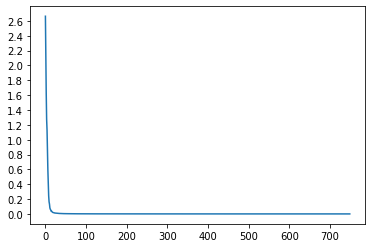

In [76]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [77]:
evaluateRandomly(encoder1, attn_decoder1)

> அவனுக்கு நீச்சல் மீது பற்று உண்டு
= he is fond of swimming .
< he is fond of swimming . <EOS>

> அவளுக்கு எட்டு வயது
= she is eight .
< she is eight . <EOS>

> அவன் இன்னும் இருக்கிறான்
= he is still here .
< he is still here . <EOS>

> அவனுக்கு இறந்து போவதென்றால் பயம்
= he is afraid of death .
< he is afraid of death . <EOS>

> அவர்கள் கிளம்ப இருக்கிறார்கள்
= they re about to leave .
< they re about to leave . <EOS>

> அவனுக்கு நீச்சல் மீது பற்று உண்டு
= he is fond of swimming .
< he is fond of swimming . <EOS>

> என் மகனைப் பற்றி பெருமைப் படுகிறேன்
= i m proud of my son .
< i m proud of my son . <EOS>

> எப்படி பதில் சொல்வது என்பதில் நான் உறுதியாக இல்லை.
= i m not sure how to answer this .
< i m not sure how to answer this . <EOS>

> எனக்குக் கரடிகளைக கண்டால் பயம்
= i am afraid of bears .
< i am afraid of bears . <EOS>

> நான் வேலை பளுவினால் சோர்வாகயிருக்கிறேன்
= i am tired of my work .
< i am tired of my work . <EOS>



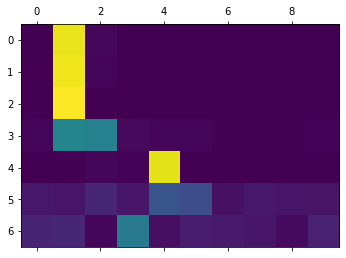

In [86]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "அவனுக்கு நீச்சல் மீது பற்று உண்டு")
plt.matshow(attentions.numpy())

In [87]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [88]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

In [95]:
print(random.choice(pairs)[0])

அவன் வருவது நிச்சயம்


input = என் மகனைப் பற்றி பெருமைப் படுகிறேன்
output = i m proud of my son . <EOS>


/home/crayondata.com/sundararaman/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2958 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/crayondata.com/sundararaman/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3016 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/crayondata.com/sundararaman/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3007 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/crayondata.com/sundararaman/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2992 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/crayondata.com/sundararaman/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2975 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cray

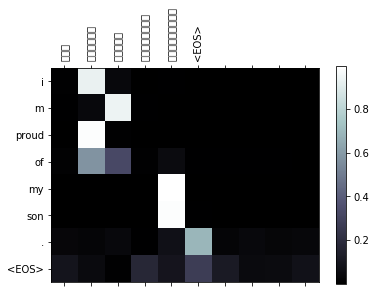

In [96]:
evaluateAndShowAttention(random.choice(pairs)[0])


input = எனக்குக் கரடிகளைக கண்டால் பயம்
output = i am afraid of bears . <EOS>


/home/crayondata.com/sundararaman/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/crayondata.com/sundararaman/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/crayondata.com/sundararaman/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2995 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/crayondata.com/sundararaman/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 2979 missing from current font.
  font.set_text(s, 0, flags=flags)


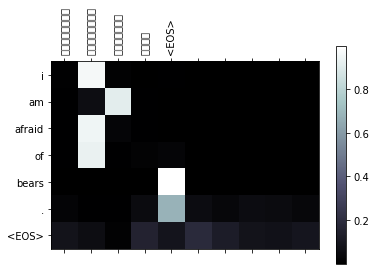

In [97]:
evaluateAndShowAttention(random.choice(pairs)[0])


input = நான் வேலை பளுவினால் சோர்வாகயிருக்கிறேன்
output = i am tired of my work . <EOS>


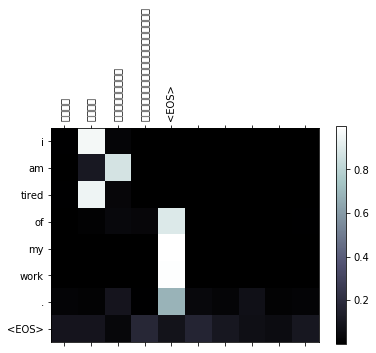

In [109]:
evaluateAndShowAttention(random.choice(pairs)[0])


In [133]:
import matplotlib


'agg'

In [134]:
matplotlib.use("TkAgg")

In [148]:
%matplotlib inline
# sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

In [141]:
matplotlib.get_backend()

'TkAgg'

# Reference
* https://www.manythings.org/anki/